<a href="https://colab.research.google.com/github/mohammedwttd/Community-In-The-Dark/blob/Mohammed/Community%20In%20The%20Dark%20v.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Community In The Dark 🦇

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# ----------------------------
# Cost Functions (L1, L2, L∞)
# ----------------------------
def cost_l1(x_old, x_new):
    return np.sum(np.abs(x_new - x_old))

def cost_l2(x_old, x_new):
    return np.linalg.norm(x_new - x_old)

def cost_linf(x_old, x_new):
    return np.max(np.abs(x_new - x_old))

# ----------------------------
# Reward Function (Variant B only)
# ----------------------------
# Reward 1 for accepted, -1 for denied.
def reward_function(label):
    return 1 if label == 1 else -1

# ----------------------------
# Agent Class
# ----------------------------
class Agent:
    def __init__(self, features, true_label=None):
        self.features = features
        self.initial_features = features.copy()  # store original position for baseline measurement & visualization
        self.true_label = true_label             # assigned by the true classifier
        self.modified = False                    # whether agent has modified its features
        self.explored = False                    # whether the agent participated in exploration

    def modify_features(self, modification, cost_func):
        new_features = self.features + modification
        c = cost_func(self.features, new_features)
        self.features = new_features
        self.modified = True
        return c

# ----------------------------
# Simulation Environment Class
# ----------------------------
class SimulationEnv:
    def __init__(self,
                 hidden_dim=10,
                 num_agents=100,
                 cost_function='l1'):
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents

        # Map cost function string to function.
        self.cost_functions = {'l1': cost_l1, 'l2': cost_l2, 'linf': cost_linf}
        if cost_function not in self.cost_functions:
            raise ValueError("Unsupported cost function. Choose from 'l1', 'l2', or 'linf'.")
        self.cost_func = self.cost_functions[cost_function]

        # ----------------------------
        # True (Hidden) Classifier
        # ----------------------------
        self.classifier_weights = np.random.randn(hidden_dim)
        self.classifier_bias = np.random.randn()

        # ----------------------------
        # Proposed Classifier (SVM)
        # ----------------------------
        # This will be trained on exploration data.
        self.proposed_svm = None

        # Containers to hold exploration data.
        self.exploration_data_X = []
        self.exploration_data_y = []

        # Generate the agent community; each agent's true label is determined by the hidden classifier.
        self.agents = self.generate_agents()
        # To store our approach utilities from the exploitation phase.
        self.last_utilities = None

    def get_axis_limits(self, margin=1):
        base_positions = np.array([agent.initial_features for agent in self.agents])
        x_min = np.min(base_positions[:, 0]) - margin
        x_max = np.max(base_positions[:, 0]) + margin
        y_min = np.min(base_positions[:, 1]) - margin
        y_max = np.max(base_positions[:, 1]) + margin
        return x_min, x_max, y_min, y_max

    # TODO: Think about addind bias here, maybe ration that we want to have 1 and -1
    def generate_agents(self):
        # This function genreates the agents vectors, which are of dim hidden_dim.
        # Ensure that there is at least one accepted (label 1) and one rejected (label -1) agent.
        while True:
            agents = []
            for _ in range(self.num_agents):
                features = np.random.randn(self.hidden_dim)
                score = np.dot(features, self.classifier_weights) + self.classifier_bias
                label = 1 if score >= 0 else -1
                agent = Agent(features, true_label=label)
                agents.append(agent)
            labels = [agent.true_label for agent in agents]
            if 1 in labels and -1 in labels:
                break
        return agents

    def classify_agent(self, agent):
        score = np.dot(agent.features, self.classifier_weights) + self.classifier_bias
        return 1 if score >= 0 else -1

    def proposed_predict(self, features):
        if self.proposed_svm is None:
            raise ValueError("Proposed SVM has not been trained yet.")
        score = self.proposed_svm.decision_function(features.reshape(1, -1))[0]
        return 1 if score >= 0 else -1

    def train_proposed_classifier(self):
        if len(self.exploration_data_X) == 0:
            return
        X = np.array(self.exploration_data_X)
        y = np.array(self.exploration_data_y)
        # Check if there are at least two distinct classes.
        if len(np.unique(y)) < 2:
            self.proposed_svm = None
            return
        self.proposed_svm = SVC(kernel='linear', C=10)
        self.proposed_svm.fit(X, y)

    def simulation_step(self):
        for agent in self.agents:
            agent.true_label = self.classify_agent(agent)

    def run_exploration_phase(self, exploration_budget=10):
        total_exploration_cost = 0

        # When the budget is at least 2, guarantee that the first two explored agents have different labels.
        if exploration_budget < 2:
            chosen_agents = np.random.choice(self.agents, size=exploration_budget, replace=False)
        else:
            accepted_agents = [agent for agent in self.agents if self.classify_agent(agent) == 1]
            rejected_agents = [agent for agent in self.agents if self.classify_agent(agent) == -1]

            if accepted_agents and rejected_agents:
                first_agent = np.random.choice(accepted_agents)
                second_agent = np.random.choice(rejected_agents)
            else:
                # Fallback: if one group is empty (unlikely), choose two randomly.
                chosen_agents = np.random.choice(self.agents, size=2, replace=False)
                first_agent, second_agent = chosen_agents[0], chosen_agents[1]

            remaining_agents = [agent for agent in self.agents if agent not in [first_agent, second_agent]]
            remaining_budget = exploration_budget - 2

            if remaining_budget > 0:
                additional_agents = np.random.choice(remaining_agents, size=remaining_budget, replace=False)
                chosen_agents = [first_agent, second_agent] + list(additional_agents)
            else:
                chosen_agents = [first_agent, second_agent]

        for agent in chosen_agents:
            true_label = self.classify_agent(agent)
            agent.true_label = true_label
            agent.explored = True
            self.exploration_data_X.append(agent.features.copy())
            self.exploration_data_y.append(true_label)
            total_exploration_cost += 1

        self.train_proposed_classifier()
        return total_exploration_cost

    def apply_investment(self, agent, modification):
        cost_incurred = agent.modify_features(modification, self.cost_func)
        new_true_label = self.classify_agent(agent)
        reward = reward_function(new_true_label)
        utility = reward - cost_incurred
        return utility, cost_incurred, reward, new_true_label

    def run_exploitation_phase(self, retrain_every = None):
        utilities = []
        gain_threshold = 2
        iter = 0
        for agent in self.agents:
            if agent.explored:
                utilities.append(reward_function(agent.true_label))
                continue

            true_label = self.classify_agent(agent)
            if true_label == 1:
                utilities.append(reward_function(true_label))
                continue

            if self.proposed_svm is None:
                utilities.append(reward_function(true_label))
                continue

            f_prop = self.proposed_svm.decision_function(agent.features.reshape(1, -1))[0]
            if f_prop >= 0:
                utilities.append(reward_function(true_label))
            else:
                iter += 1
                weight_vector = self.proposed_svm.coef_[0]
                norm_w = np.linalg.norm(weight_vector)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = weight_vector / norm_w
                alpha_min = -f_prop / norm_w
                projected_features = agent.features + alpha_min * d_unit
                projected_cost = self.cost_func(agent.features, projected_features)
                if projected_cost < gain_threshold:
                    util, _, _, new_true_label = self.apply_investment(agent, alpha_min * d_unit)
                    utilities.append(util)
                    self.exploration_data_X.append(agent.features.copy())
                    self.exploration_data_y.append(new_true_label)
                    if retrain_every and iter % retrain_every == 0:
                      self.train_proposed_classifier()
                else:
                    utilities.append(reward_function(true_label))
        self.last_utilities = utilities
        return utilities

    def classifier_understanding_metric(self, num_samples=1000):
        if self.proposed_svm is None:
            raise ValueError("Proposed classifier is not trained yet.")
        samples = np.random.randn(num_samples, self.hidden_dim)
        true_scores = np.dot(samples, self.classifier_weights) + self.classifier_bias
        true_labels = np.where(true_scores >= 0, 1, -1)
        svm_predictions = self.proposed_svm.predict(samples)
        accuracy = np.mean(true_labels == svm_predictions)
        return accuracy

    def compute_acceptance_counts(self, gain_threshold=2):
        optimal_modification_acceptance = 0
        no_modification_acceptance = 0
        for agent in self.agents:
            initial_score = np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias
            if initial_score >= 0:
                no_modification_acceptance += 1
                optimal_modification_acceptance += 1
            else:
                norm_w = np.linalg.norm(self.classifier_weights)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = self.classifier_weights / norm_w
                alpha_min_true = -initial_score / norm_w
                modification = alpha_min_true * d_unit
                cost_required = self.cost_func(agent.initial_features, agent.initial_features + modification)
                if cost_required < gain_threshold:
                    optimal_modification_acceptance += 1
        our_approach_acceptance = sum(1 for agent in self.agents if self.classify_agent(agent) == 1)
        return optimal_modification_acceptance, no_modification_acceptance, our_approach_acceptance

    def compute_utility_metrics(self, gain_threshold=2):
        no_mod_util = 0.0
        optimal_util = 0.0
        for agent in self.agents:
            init_score = np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias
            if init_score >= 0:
                no_mod_util += 1  # reward = +1
                optimal_util += 1
            else:
                no_mod_util += -1  # no modification: reward = -1
                norm_w = np.linalg.norm(self.classifier_weights)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = self.classifier_weights / norm_w
                alpha_min_true = -init_score / norm_w
                candidate = agent.initial_features + alpha_min_true * d_unit
                cost_required = self.cost_func(agent.initial_features, candidate)
                if cost_required < gain_threshold:
                    optimal_util += (1 - cost_required)
                else:
                    optimal_util += -1
        our_util = sum(self.last_utilities) if self.last_utilities is not None else None
        return optimal_util, no_mod_util, our_util

    def reset_simulation(self):
        for agent in self.agents:
            agent.features = agent.initial_features.copy()
            agent.modified = False
            agent.explored = False
        self.exploration_data_X = []
        self.exploration_data_y = []
        self.proposed_svm = None
        self.last_utilities = None

    def plot_environment(self):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        self.simulation_step()

        accepted_list = []
        denied_list = []
        modified_list = []
        for agent in self.agents:
            label = self.classify_agent(agent)
            if label == 1:
                accepted_list.append(agent.features)
            else:
                denied_list.append(agent.features)
            if agent.modified:
                modified_list.append(agent.features)

        accepted = np.array(accepted_list)
        denied = np.array(denied_list)
        modified_points = np.array(modified_list)

        plt.figure(figsize=(8, 6))
        if accepted.shape[0] > 0:
            plt.scatter(accepted[:, 0], accepted[:, 1], c='green', label='Accepted')
        if denied.shape[0] > 0:
            plt.scatter(denied[:, 0], denied[:, 1], c='red', label='Denied')
        if modified_points.shape[0] > 0:
            plt.scatter(modified_points[:, 0], modified_points[:, 1],
                        facecolors='none', edgecolors='blue', s=100, linewidths=1.5,
                        label='Modified Agents')

        for agent in self.agents:
            if agent.modified:
                x_old, y_old = agent.initial_features[0], agent.initial_features[1]
                x_new, y_new = agent.features[0], agent.features[1]
                plt.arrow(x_old, y_old, x_new - x_old, y_new - y_old,
                          head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.7)

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        if self.proposed_svm is not None:
            coef = self.proposed_svm.coef_[0]
            intercept = self.proposed_svm.intercept_[0]
            if coef[1] != 0:
                y_values_prop = (-intercept - coef[0]*x_values) / coef[1]
                plt.plot(x_values, y_values_prop, 'k--', label='Proposed Decision Boundary')
            else:
                x_boundary_prop = -intercept / coef[0]
                plt.axvline(x=x_boundary_prop, color='k', linestyle='--', label='Proposed Decision Boundary')

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.title('Agent Distribution, Classifiers, and Modified Agents (Our Approach)')
        plt.show()

    def plot_optimal_modification_scenario(self, gain_threshold=2):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        final_positions = []
        modifications = []
        accepted_indices = []

        for idx, agent in enumerate(self.agents):
            init_feat = agent.initial_features.copy()
            score = np.dot(init_feat, self.classifier_weights) + self.classifier_bias

            if score >= 0:
                final_positions.append(init_feat)
                modifications.append(None)
                accepted_indices.append(idx)
            else:
                w = self.classifier_weights
                norm_w = np.linalg.norm(w)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = w / norm_w
                alpha_min_true = -score / norm_w
                candidate = init_feat + alpha_min_true * d_unit
                cost_required = self.cost_func(init_feat, candidate)
                if cost_required < gain_threshold:
                    final_positions.append(candidate)
                    modifications.append(candidate - init_feat)
                    final_score = np.dot(candidate, self.classifier_weights) + self.classifier_bias
                    if final_score >= 0:
                        accepted_indices.append(idx)
                else:
                    final_positions.append(init_feat)
                    modifications.append(None)

        final_positions = np.array(final_positions)
        plt.figure(figsize=(8, 6))

        accepted_pts = final_positions[[i for i in accepted_indices]]
        denied_pts = np.delete(final_positions, accepted_indices, axis=0)

        if accepted_pts.size > 0:
            plt.scatter(accepted_pts[:, 0], accepted_pts[:, 1], c='green', label='Accepted (Optimal True)')
        if denied_pts.size > 0:
            plt.scatter(denied_pts[:, 0], denied_pts[:, 1], c='red', label='Denied (Optimal True)')

        for i, mod_vec in enumerate(modifications):
            if mod_vec is not None:
                start_x, start_y = self.agents[i].initial_features
                plt.arrow(start_x, start_y, mod_vec[0], mod_vec[1],
                          head_width=0.05, head_length=0.1, fc='blue', ec='blue', alpha=0.7)

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Optimal Modifications (Full Knowledge of True Classifier)')
        plt.legend()
        plt.show()

    def plot_base_version(self):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        base_positions = np.array([agent.initial_features for agent in self.agents])
        true_scores = np.dot(base_positions, self.classifier_weights) + self.classifier_bias
        base_labels = np.where(true_scores >= 0, 1, -1)

        accepted = base_positions[base_labels == 1]
        denied = base_positions[base_labels == -1]

        plt.figure(figsize=(8, 6))
        if accepted.shape[0] > 0:
            plt.scatter(accepted[:, 0], accepted[:, 1], c='green', label='Accepted')
        if denied.shape[0] > 0:
            plt.scatter(denied[:, 0], denied[:, 1], c='red', label='Denied')

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0] * x_values) / self.classifier_weights[1]
            plt.plot(x_values, y_values, 'b--', label='True Decision Boundary')
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            plt.axvline(x=x_boundary, color='b', linestyle='--', label='True Decision Boundary')

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.title('Base Version: Agent Distribution (Initial Features)')
        plt.show()

# ----------------------------
# New Function: Plot Utility vs Exploration Budget Using Existing Simulation
# ----------------------------
def plot_utility_vs_exploration_budget_using_env(sim_env):
    budgets = np.arange(0, sim_env.num_agents + 1, 1)  # e.g., 0, 2, 4, ... up to num_agents
    our_utilities_list = []

    # Reset simulation and compute base (no modification) and optimal utilities.
    sim_env.reset_simulation()
    sim_env.run_exploitation_phase()
    _, base_util, _ = sim_env.compute_utility_metrics(gain_threshold=2)
    sim_env.reset_simulation()
    optimal_util, _, _ = sim_env.compute_utility_metrics(gain_threshold=2)

    for budget in budgets:
        sim_env.reset_simulation()
        sim_env.run_exploration_phase(exploration_budget=int(budget))
        sim_env.run_exploitation_phase()
        _, _, our_util = sim_env.compute_utility_metrics(gain_threshold=2)
        our_utilities_list.append(our_util)

    plt.figure(figsize=(8,6))
    plt.plot(budgets, our_utilities_list, marker='o', label="Our Approach Utility")
    plt.axhline(y=base_util, color='red', linestyle='--', label="Base Utility (No Modification)")
    plt.axhline(y=optimal_util, color='green', linestyle='--', label="Optimal Utility")
    plt.xlabel("Exploration Budget")
    plt.ylabel("Total Utility (Sum of Rewards - Costs)")
    plt.title("Utility in Our Approach vs Exploration Budget")
    plt.legend()
    plt.show()


Initial Agents: 100
Explorers: 30  |  Exploiters: 70
Classifier Understanding Accuracy: 0.968
No Modification Acceptance: 75 / 100  | Total Utility: 50.0
Optimal Modification Acceptance: 100 / 100  | Total Utility: 82.81416893723781
Our Approach Acceptance without retraining: 75 / 100  | Total Utility: 39.80001741463357


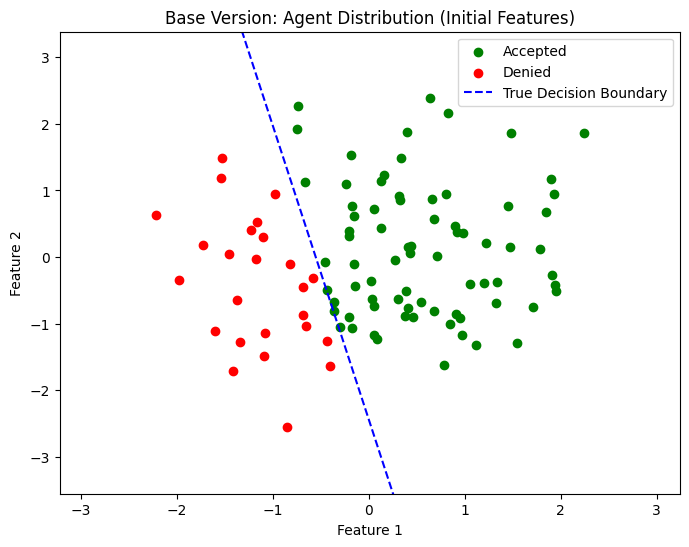

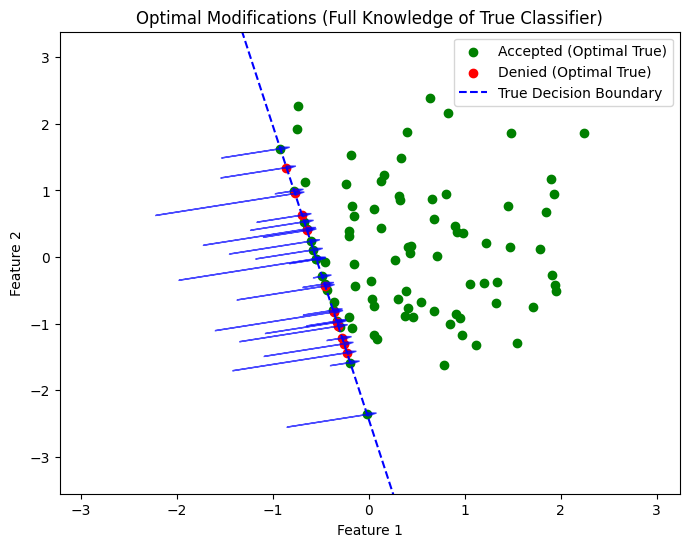

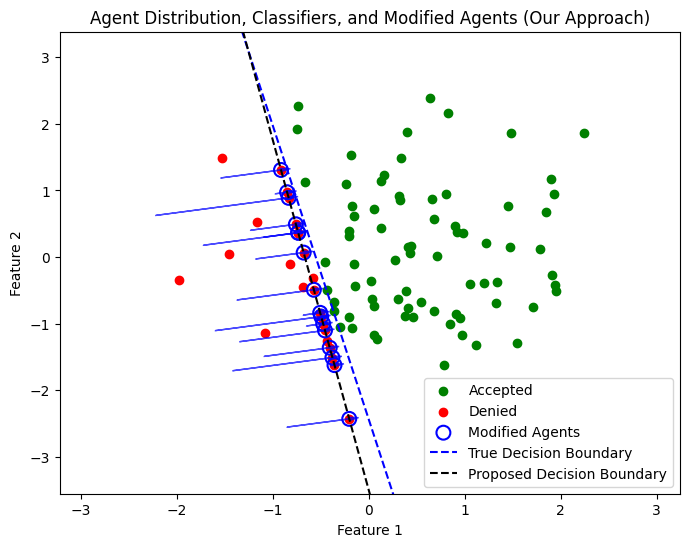

In [28]:

# ----------------------------
# Main: Running the Simulation
# ----------------------------
if __name__ == "__main__":
    seed = 0
    np.random.seed(seed)

    env = SimulationEnv(hidden_dim=2, num_agents=100, cost_function='l2')

    print("Initial Agents:", len(env.agents))
    exploration_cost = env.run_exploration_phase(exploration_budget=30)  # Note: the first two agents always have different labels (exploration budget must be greater than 2)
    print("Explorers:", exploration_cost, " | ", "Exploiters:", len(env.agents) - exploration_cost)

    understanding_accuracy = env.classifier_understanding_metric(num_samples=1000)
    print("Classifier Understanding Accuracy:", understanding_accuracy)

    our_utilities = env.run_exploitation_phase()
    our_total_utility = sum(our_utilities) if our_utilities is not None else None

    optimal_acc, no_mod_acc, our_acc = env.compute_acceptance_counts(gain_threshold=2)
    optimal_util, no_mod_util, our_util = env.compute_utility_metrics(gain_threshold=2)
    print("No Modification Acceptance:", no_mod_acc, "/", len(env.agents), " | Total Utility:", no_mod_util)
    print("Optimal Modification Acceptance:", optimal_acc, "/", len(env.agents), " | Total Utility:", optimal_util)
    print("Our Approach Acceptance without retraining:", our_acc, "/", len(env.agents), " | Total Utility:", our_total_utility)

    # Plot the original graphs.
    env.plot_base_version()
    env.plot_optimal_modification_scenario(gain_threshold=2)
    env.plot_environment()


Initial Agents: 100
Explorers: 30  |  Exploiters: 70
Classifier Understanding Accuracy: 0.968
No Modification Acceptance: 75 / 100  | Total Utility: 50.0
Optimal Modification Acceptance: 100 / 100  | Total Utility: 82.81416893723781
Our Approach Acceptance with retraining: 80 / 100  | Total Utility: 48.912543952258176


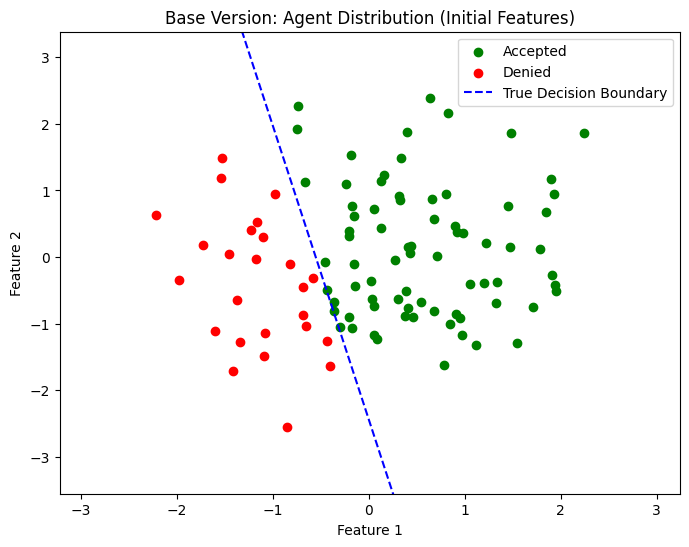

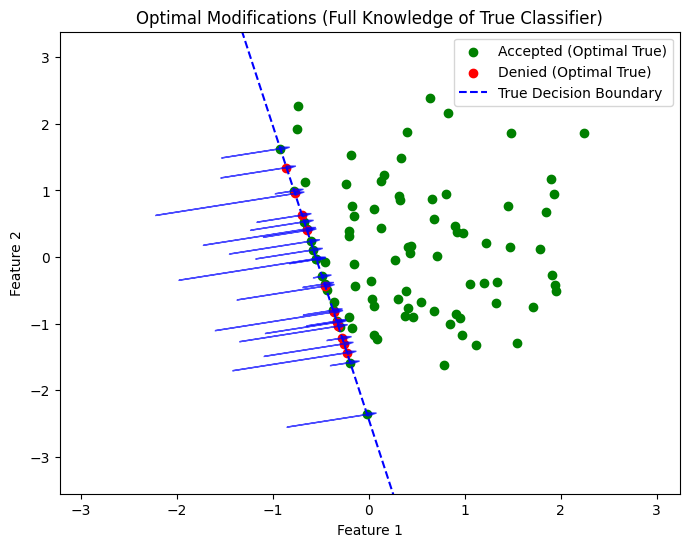

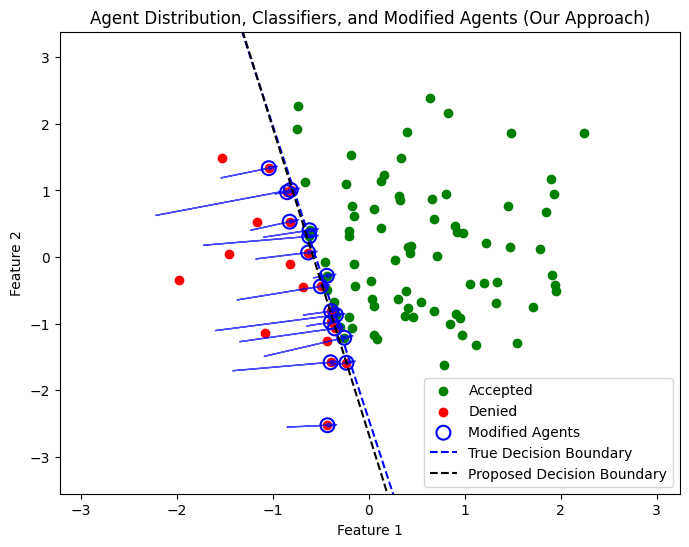

In [30]:
if __name__ == "__main__":
    seed = 0
    np.random.seed(seed)

    env = SimulationEnv(hidden_dim=2, num_agents=100, cost_function='l2')

    print("Initial Agents:", len(env.agents))
    exploration_cost = env.run_exploration_phase(exploration_budget=30)  # Note: the first two agents always have different labels (exploration budget must be greater than 2)
    print("Explorers:", exploration_cost, " | ", "Exploiters:", len(env.agents) - exploration_cost)

    understanding_accuracy = env.classifier_understanding_metric(num_samples=1000)
    print("Classifier Understanding Accuracy:", understanding_accuracy)

    our_utilities = env.run_exploitation_phase(retrain_every=1)
    our_total_utility = sum(our_utilities) if our_utilities is not None else None

    optimal_acc, no_mod_acc, our_acc = env.compute_acceptance_counts(gain_threshold=2)
    optimal_util, no_mod_util, our_util = env.compute_utility_metrics(gain_threshold=2)
    print("No Modification Acceptance:", no_mod_acc, "/", len(env.agents), " | Total Utility:", no_mod_util)
    print("Optimal Modification Acceptance:", optimal_acc, "/", len(env.agents), " | Total Utility:", optimal_util)
    print("Our Approach Acceptance with retraining:", our_acc, "/", len(env.agents), " | Total Utility:", our_total_utility)

    # Plot the original graphs.
    env.plot_base_version()
    env.plot_optimal_modification_scenario(gain_threshold=2)
    env.plot_environment()


In [23]:

    #     # ----- New Section: Plot Total Utility as a Function of Exploration Budget -----
    # exploration_budgets = list(range(0, 21, 2))  # For example, budgets: 0, 2, 4, ..., 20
    # total_utilities = []
    # for budget in exploration_budgets:
    #     # For each exploration budget, create a new environment.
    #     env_temp = SimulationEnv(hidden_dim=2,
    #                              num_agents=50,
    #                              cost_function='l1')
    #     env_temp.run_exploration_phase(exploration_budget=budget)
    #     utilities_temp = env_temp.run_exploitation_phase()
    #     total_utilities.append(np.sum(utilities_temp))

    # plt.figure(figsize=(8, 6))
    # plt.plot(exploration_budgets, total_utilities, marker='o')
    # plt.xlabel('Exploration Budget')
    # plt.ylabel('Total Utility')
    # plt.title('Total Utility as a Function of Exploration Budget')
    # plt.grid(True)
    # plt.show()